# **Portfolio Optimization using Deep Reinforcement Learning**

## A comprehensive capstone project implementing Deep RL for portfolio optimization in finance.

### Table of Contents
1. **Phase 1**:  Data Collection & Feature Engineering
2. **Phase 2**:  Trading Environment
3. **Phase 3**: Deep RL Agent Training
4. **Phase 4**: Backtesting & Benchmark Comparisons
5. **Phase 5**: Feature Importance Analysis
6. **Phase 6**: Visualization & Results

## Setup and Installation

In [3]:
!pip install yfinance pandas numpy matplotlib seaborn gymnasium stable-baselines3 torch scipy scikit-learn plotly

In [4]:
# ============================================
# GOOGLE COLAB SETUP
# ============================================

# Install required packages
!pip install -q yfinance gymnasium stable-baselines3[extra] torch

# Check GPU availability
import torch
if torch.cuda.is_available():
    print(f"✅ GPU Available: {torch. cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ No GPU detected - running on CPU")

# Set device for Stable-Baselines3
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"   Using device: {device}")

✅ GPU Available: Tesla T4
   Memory: 15.8 GB
   Using device: cuda


In [5]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib. pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from typing import Tuple, Dict, List, Optional

# Finance
import yfinance as yf

# ML/RL
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn

# Stable Baselines 3
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor

# Sklearn
from sklearn.preprocessing import StandardScaler

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)
torch.manual_seed(42)

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")

All libraries imported successfully!
PyTorch version: 2.9.0+cu126


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


# Phase 1: Data Collection & Preprocessing

**1. DATA COLLECTION**

Tickers: ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'JPM', 'XOM', 'PFE', 'KO', 'SPY']


[*********************100%***********************]  9 of 9 completed



Data downloaded successfully!
Date range: 2018-01-02 00:00:00 to 2023-12-29 00:00:00
Total trading days: 1509
ASSET STATISTICS

Close Prices Shape: (1509, 9)
Returns Shape: (1508, 9)

--- Daily Returns Summary ---
Ticker       AAPL       AMZN      GOOGL        JPM         KO       MSFT  \
count   1508.0000  1508.0000  1508.0000  1508.0000  1508.0000  1508.0000   
mean       0.0012     0.0009     0.0008     0.0006     0.0004     0.0012   
std        0.0200     0.0223     0.0197     0.0192     0.0129     0.0190   
min       -0.1286    -0.1405    -0.1163    -0.1496    -0.0967    -0.1474   
25%       -0.0083    -0.0104    -0.0085    -0.0083    -0.0052    -0.0081   
50%        0.0012     0.0012     0.0010     0.0005     0.0007     0.0013   
75%        0.0119     0.0122     0.0110     0.0093     0.0065     0.0110   
max        0.1198     0.1354     0.0962     0.1801     0.0648     0.1422   

Ticker        PFE        SPY        XOM  
count   1508.0000  1508.0000  1508.0000  
mean       0.000

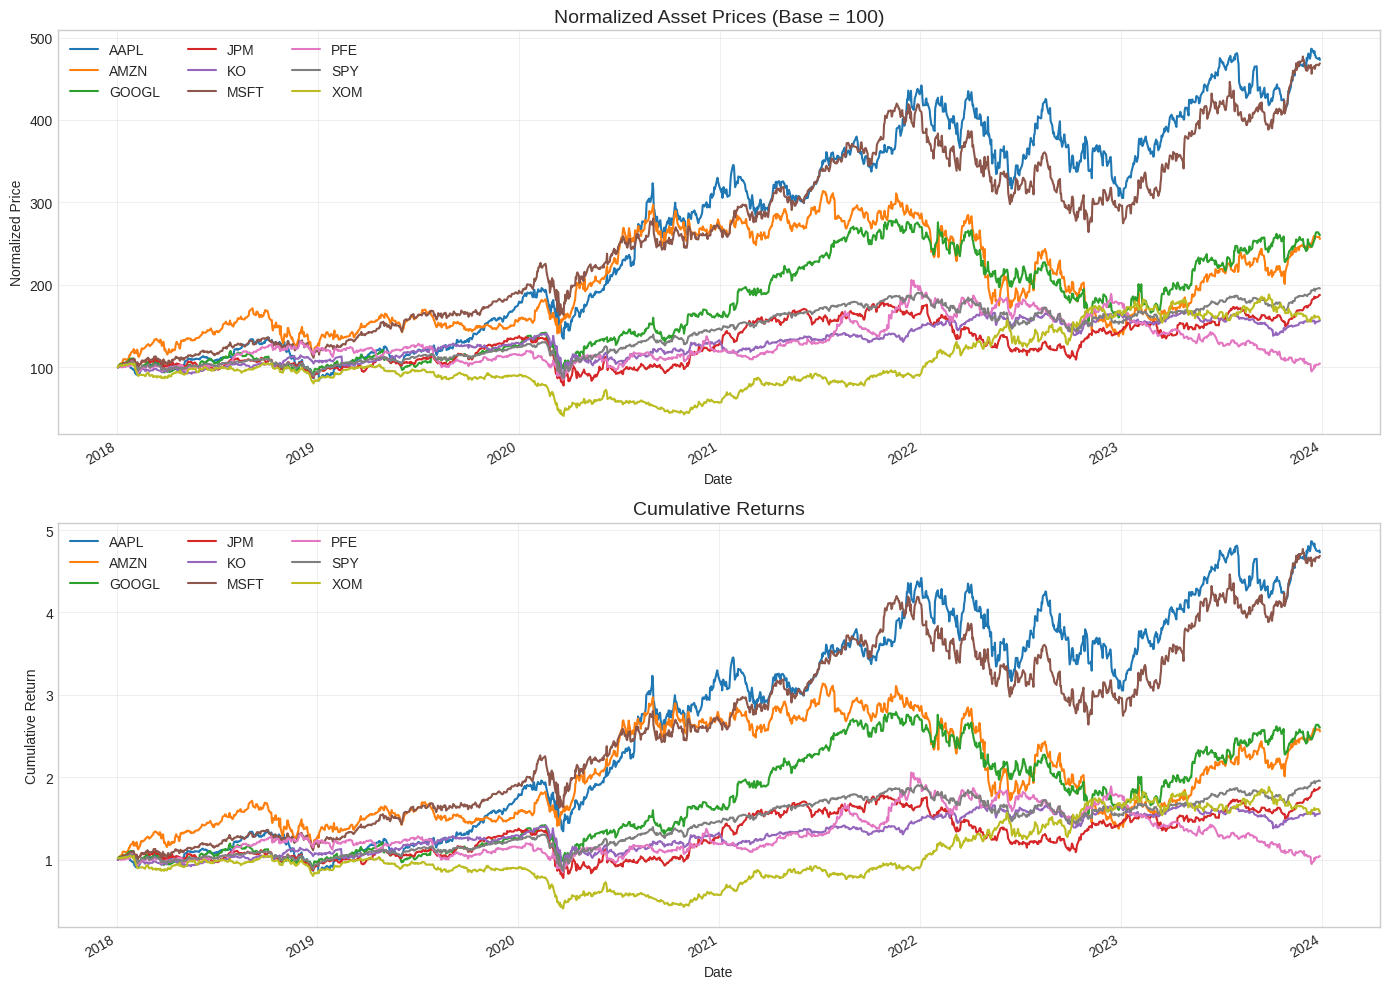

In [6]:
# Select a diverse set of assets (stocks across different sectors)
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'JPM', 'XOM', 'PFE', 'KO', 'SPY']

print("Downloading historical data...")
print(f"Tickers: {tickers}")

# Download historical data
data = yf.download(tickers, start='2018-01-01', end='2023-12-31', progress=True)

print(f"\nData downloaded successfully!")
print(f"Date range: {data.index[0]} to {data.index[-1]}")
print(f"Total trading days: {len(data)}")

# %%
# Extract price data
close_prices = data['Close'].copy() # Changed 'Adj Close' to 'Close'
close_prices = close_prices.dropna()

# Calculate daily returns
returns = close_prices.pct_change().dropna()

# Display basic statistics
print("=" * 60)
print("ASSET STATISTICS")
print("=" * 60)
print(f"\nClose Prices Shape: {close_prices.shape}")
print(f"Returns Shape: {returns.shape}")

print("\n--- Daily Returns Summary ---")
print(returns.describe().round(4))

# %%
# Visualize price data
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Normalized prices
normalized_prices = close_prices / close_prices.iloc[0] * 100
normalized_prices.plot(ax=axes[0], linewidth=1.5)
axes[0].set_title('Normalized Asset Prices (Base = 100)', fontsize=14)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Normalized Price')
axes[0].legend(loc='upper left', ncol=3)
axes[0].grid(True, alpha=0.3)

# Cumulative returns
cumulative_returns = (1 + returns).cumprod()
cumulative_returns.plot(ax=axes[1], linewidth=1.5)
axes[1].set_title('Cumulative Returns', fontsize=14)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Return')
axes[1].legend(loc='upper left', ncol=3)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('price_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

**2. DATA PREPROCESSING**

In [7]:
# Remove SPY from asset list for trading (keep for benchmark)
asset_names = [t for t in tickers if t != 'SPY']
n_assets = len(asset_names)

print(f"Trading Assets: {asset_names}")
print(f"Number of Assets: {n_assets}")

# Asset returns (excluding SPY)
asset_returns = returns[asset_names]. copy()

# Use returns as features (simplified version)
features = returns.copy()

# Normalize features
scaler = StandardScaler()
features_normalized = pd.DataFrame(
    scaler.fit_transform(features),
    index=features. index,
    columns=features. columns
)

print(f"\nFeatures Shape: {features_normalized.shape}")
print(f"Asset Returns Shape: {asset_returns. shape}")

Trading Assets: ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'JPM', 'XOM', 'PFE', 'KO']
Number of Assets: 8

Features Shape: (1508, 9)
Asset Returns Shape: (1508, 8)


**3. TRAIN/TEST SPLIT**

In [8]:
train_ratio = 0.8
split_idx = int(len(features_normalized) * train_ratio)

# Training data
train_features = features_normalized. iloc[:split_idx]
train_returns = asset_returns.iloc[:split_idx]

# Testing data
test_features = features_normalized.iloc[split_idx:]
test_returns = asset_returns.iloc[split_idx:]

# SPY benchmark returns
spy_returns = returns['SPY'].copy()
test_spy_returns = spy_returns.iloc[split_idx:]

print("=" * 60)
print("DATA SPLIT")
print("=" * 60)
print(f"Training Period: {train_features.index[0]. date()} to {train_features.index[-1].date()}")
print(f"Training Samples: {len(train_features)}")
print(f"\nTesting Period: {test_features. index[0].date()} to {test_features.index[-1].date()}")
print(f"Testing Samples: {len(test_features)}")

DATA SPLIT
Training Period: 2018-01-03 to 2022-10-17
Training Samples: 1206

Testing Period: 2022-10-18 to 2023-12-29
Testing Samples: 302


 # Phase 2: Trading Environment

In [9]:
# ============================================
# OPTIMIZED PORTFOLIO ENVIRONMENT (FASTER)
# ============================================

class PortfolioEnvFast(gym.Env):
    """
    Optimized Portfolio Environment for faster training.
    Key optimizations:
    - Shorter episodes with random starting points
    - Simplified observation space
    - Efficient numpy operations
    """

    metadata = {'render_modes': ['human']}

    def __init__(
        self,
        features_df: pd.DataFrame,
        returns_df: pd.DataFrame,
        window_size: int = 10,
        episode_length: int = 100,  # Fixed episode length for faster training
        transaction_cost:  float = 0.001,
        initial_capital: float = 100000,
        random_start: bool = True
    ):
        super().__init__()

        self.features = features_df. values. astype(np.float32)
        self.returns = returns_df.values.astype(np.float32)
        self.n_assets = returns_df.shape[1]
        self.n_features = features_df.shape[1]
        self.window_size = window_size
        self.episode_length = episode_length
        self.transaction_cost = transaction_cost
        self. initial_capital = initial_capital
        self.random_start = random_start
        self.dates = features_df.index
        self.max_steps = len(self.features) - 1

        # Action space:  portfolio weights
        self.action_space = spaces.Box(
            low=0.0, high=1.0, shape=(self.n_assets,), dtype=np.float32
        )

        # Simplified observation:  current window flattened + current weights
        obs_dim = (self.window_size * self.n_features) + self.n_assets
        self.observation_space = spaces. Box(
            low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32
        )

        self.reset()

    def reset(self, seed:  Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)

        # Random starting point for training diversity
        if self.random_start:
            max_start = self.max_steps - self.episode_length - self.window_size
            if max_start > self.window_size:
                self.start_step = np.random.randint(self.window_size, max_start)
            else:
                self. start_step = self.window_size
        else:
            self.start_step = self.window_size

        self.current_step = self.start_step
        self.episode_step = 0
        self.weights = np.ones(self.n_assets, dtype=np.float32) / self.n_assets
        self.portfolio_value = self.initial_capital

        # History tracking
        self.portfolio_values = [self.initial_capital]
        self.weights_history = [self.weights.copy()]
        self.returns_history = []

        return self._get_observation(), {}

    def _get_observation(self) -> np.ndarray:
        # Feature window
        start_idx = max(0, self.current_step - self.window_size)
        feature_window = self.features[start_idx:self.current_step]. flatten()

        # Pad if necessary
        expected_size = self.window_size * self.n_features
        if len(feature_window) < expected_size:
            feature_window = np.pad(feature_window, (expected_size - len(feature_window), 0))

        # Combine with current weights
        obs = np.concatenate([feature_window, self.weights]).astype(np.float32)
        return obs

    def step(self, action: np.ndarray):
        # Normalize weights
        weights = np.maximum(action, 0)
        weight_sum = weights.sum()
        new_weights = weights / weight_sum if weight_sum > 0 else np.ones(self.n_assets) / self.n_assets
        new_weights = new_weights.astype(np.float32)

        # Transaction cost
        turnover = np.sum(np.abs(new_weights - self.weights))
        cost = turnover * self.transaction_cost

        # Portfolio return
        asset_returns = self.returns[self.current_step]
        portfolio_return = np.dot(new_weights, asset_returns) - cost

        # Update state
        self.portfolio_value *= (1 + portfolio_return)
        self.weights = new_weights. copy()

        # Record history
        self.portfolio_values.append(self.portfolio_value)
        self.weights_history.append(new_weights.copy())
        self.returns_history.append(portfolio_return)

        # Advance
        self.current_step += 1
        self.episode_step += 1

        # Check termination (fixed episode length OR end of data)
        terminated = (self.episode_step >= self.episode_length) or (self.current_step >= self. max_steps)
        truncated = False

        # Reward:  scaled return with small shaping for risk
        reward = portfolio_return * 100

        # Small penalty for high concentration (encourages diversification)
        concentration = np.sum(new_weights ** 2)  # Herfindahl index
        reward -= concentration * 0.1

        info = {'portfolio_value': self.portfolio_value, 'weights': new_weights}

        return self._get_observation(), reward, terminated, truncated, info

    def get_episode_metrics(self) -> dict:
        if len(self.returns_history) == 0:
            return {'total_return': 0, 'sharpe_ratio': 0, 'max_drawdown': 0, 'win_rate': 0}

        returns_array = np.array(self.returns_history)
        values_array = np.array(self. portfolio_values)

        total_return = (values_array[-1] / values_array[0]) - 1
        n_days = len(returns_array)

        volatility = np.std(returns_array) * np.sqrt(252) if n_days > 1 else 0.001
        annual_return = (1 + total_return) ** (252 / max(n_days, 1)) - 1
        sharpe_ratio = (annual_return - 0.02) / max(volatility, 0.001)

        peak = np.maximum. accumulate(values_array)
        drawdown = (peak - values_array) / peak
        max_drawdown = drawdown.max()

        win_rate = np.mean(returns_array > 0)

        return {
            'total_return':  total_return,
            'annual_return': annual_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'win_rate': win_rate,
            'n_trading_days': n_days
        }

**TEST THE ENVIRONMENT**

In [10]:
print("Testing the Portfolio Environment...")

# Create environment
env = PortfolioEnvFast(
    features_df=train_features,
    returns_df=train_returns,
    window_size=50,
    transaction_cost=0.001
)

print(f"Observation Space: {env.observation_space.shape}")
print(f"Action Space: {env.action_space.shape}")
print(f"Number of Assets: {env.n_assets}")

# Test reset
obs, info = env.reset()
print(f"\nInitial Observation Shape: {obs.shape}")
print(f"Initial Portfolio Value: ${env.portfolio_value:,.2f}")

# Test a few random steps
print("\nTesting random actions...")
for i in range(5):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"  Step {i+1}:  Reward = {reward:.4f}, Portfolio Value = ${info['portfolio_value']:,.2f}")

print("\nEnvironment test passed!")

Testing the Portfolio Environment...
Observation Space: (458,)
Action Space: (8,)
Number of Assets: 8

Initial Observation Shape: (458,)
Initial Portfolio Value: $100,000.00

Testing random actions...
  Step 1:  Reward = 1.1181, Portfolio Value = $101,130.95
  Step 2:  Reward = -0.5230, Portfolio Value = $100,620.11
  Step 3:  Reward = -0.2474, Portfolio Value = $100,385.42
  Step 4:  Reward = -0.1221, Portfolio Value = $100,282.96
  Step 5:  Reward = 0.9277, Portfolio Value = $101,230.25

Environment test passed!


# Phase 3: Deep RL Agent Training

In [11]:
# ============================================
# FIXED TRAINING CALLBACK
# ============================================

class TrainingCallback(BaseCallback):
    """Custom callback to track training progress."""

    def __init__(self, eval_env_fn, eval_freq:  int = 5000, verbose: int = 1):
        super().__init__(verbose)
        self.eval_env_fn = eval_env_fn  # Function to create fresh env
        self.eval_freq = eval_freq
        self. history = []

    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            try:
                # Create a fresh evaluation environment each time
                eval_env = self.eval_env_fn()

                obs, _ = eval_env.reset()
                done = False
                max_steps = 1000  # Safety limit to prevent infinite loops
                step_count = 0

                while not done and step_count < max_steps:
                    action, _ = self.model.predict(obs, deterministic=True)
                    obs, reward, terminated, truncated, info = eval_env.step(action)
                    done = terminated or truncated
                    step_count += 1

                # Get metrics
                metrics = eval_env.get_episode_metrics()
                if metrics:  # Only add if we got valid metrics
                    metrics['timestep'] = self.n_calls
                    self.history.append(metrics)

                    if self.verbose:
                        print(f"\n[Eval @ {self.n_calls:,}] "
                              f"Return: {metrics. get('total_return', 0):.2%} | "
                              f"Sharpe: {metrics.get('sharpe_ratio', 0):.3f} | "
                              f"MaxDD: {metrics.get('max_drawdown', 0):.2%}")
            except Exception as e:
                if self.verbose:
                    print(f"\n[Eval @ {self. n_calls:,}] Evaluation failed: {e}")

        return True

**CREATE TRAINING AND EVALUATION ENVIRONMENTS**

In [12]:
# ============================================
# FAST TRAINING SETUP
# ============================================

# Optimized parameters
WINDOW_SIZE = 10
EPISODE_LENGTH = 50  # Shorter episodes = faster training
TOTAL_TIMESTEPS = 30000  # Reduced but effective

def make_fast_train_env():
    env = PortfolioEnvFast(
        features_df=train_features,
        returns_df=train_returns,
        window_size=WINDOW_SIZE,
        episode_length=EPISODE_LENGTH,
        transaction_cost=0.001,
        random_start=True  # Important for learning diversity
    )
    return env

# Create vectorized environment
vec_train_env = DummyVecEnv([make_fast_train_env])

print("✅ Fast training environment created!")
print(f"   Window size: {WINDOW_SIZE}")
print(f"   Episode length: {EPISODE_LENGTH}")
print(f"   Training samples: {len(train_features)}")

✅ Fast training environment created!
   Window size: 10
   Episode length: 50
   Training samples: 1206


**CREATE AND TRAIN PPO AGENT**

A PPO (Proximal Policy Optimization) agent in reinforcement learning is an AI that learns to make decisions by training a policy (its strategy) using a stable, efficient algorithm that balances exploration and exploitation, ensuring updates don't drastically change its behavior.

In [ ]:
# ============================================
# OPTIMIZED PPO TRAINING (NO CALLBACK)
# ============================================

print("\n" + "=" * 60)
print("TRAINING PPO AGENT (OPTIMIZED)")
print("=" * 60)

# Optimized PPO hyperparameters for faster convergence
model = PPO(
    "MlpPolicy",
    vec_train_env,
    learning_rate=1e-3,        # Higher LR for faster learning
    n_steps=512,               # Smaller buffer = more frequent updates
    batch_size=128,            # Larger batch for stability
    n_epochs=5,                # Fewer epochs per update
    gamma=0.95,                # Slightly lower discount
    gae_lambda=0.9,
    clip_range=0.2,
    ent_coef=0.02,             # More exploration
    vf_coef=0.5,
    max_grad_norm=0.5,
    verbose=1,                 # Show training progress
    seed=42,
    device="auto",
    policy_kwargs=dict(
        net_arch=dict(pi=[64, 64], vf=[64, 64])  # Smaller network = faster
    )
)

print(f"\nTraining for {TOTAL_TIMESTEPS: ,} timesteps...")
print("This should take 1-3 minutes.\n")

# Train WITHOUT callback (much faster)
model.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    progress_bar=True
)

print("\n✅ Training complete!")

# Save with absolute path to ensure it goes to the correct directory
import os
save_path = "/Users/yoni/Documents/ML-zoomcamp/Capestone_project/portfolio_ppo_fast"
model.save(save_path)
print(f"Model saved to: {save_path}.zip")


TRAINING PPO AGENT (OPTIMIZED)
Using cuda device


Output()


Training for  30,000 timesteps...
This should take 1-3 minutes.



----------------------------
| time/              |     |
|    fps             | 425 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 364         |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.017833754 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.4       |
|    explained_variance   | -0.109      |
|    learning_rate        | 0.001       |
|    loss                 | 2.23        |
|    n_updates            | 5           |
|    policy_gradient_loss | -0.0519     |
|    std                  | 1           |
|    value_loss           | 5.66        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 396         |
|    iterations           | 3           |
|    time_elapsed         | 3           |
|    total_timesteps      | 1536        |
| train/                  |             |
|    approx_kl            | 0.015051408 |
|    clip_fraction        | 0.0785      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.4       |
|    explained_variance   | 0.0501      |
|    learning_rate        | 0.001       |
|    loss                 | 1.7         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0393     |
|    std                  | 1           |
|    value_loss           | 4.06        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 436         |
|    iterations           | 4           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.017447993 |
|    clip_fraction        | 0.0875      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.4       |
|    explained_variance   | 0.0823      |
|    learning_rate        | 0.001       |
|    loss                 | 2.53        |
|    n_updates            | 15          |
|    policy_gradient_loss | -0.0417     |
|    std                  | 1           |
|    value_loss           | 6.01        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 471         |
|    iterations           | 5           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.013728477 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.4       |
|    explained_variance   | 0.0488      |
|    learning_rate        | 0.001       |
|    loss                 | 3.88        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0335     |
|    std                  | 1.01        |
|    value_loss           | 8.91        |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 498        |
|    iterations           | 6          |
|    time_elapsed         | 6          |
|    total_timesteps      | 3072       |
| train/                  |            |
|    approx_kl            | 0.02622468 |
|    clip_fraction        | 0.149      |
|    clip_range           | 0.2        |
|    entropy_loss         | -11.4      |
|    explained_variance   | 0.085      |
|    learning_rate        | 0.001      |
|    loss                 | 0.855      |
|    n_updates            | 25         |
|    policy_gradient_loss | -0.0498    |
|    std                  | 1.01       |
|    value_loss           | 3.06       |
----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 519       |
|    iterations           | 7         |
|    time_elapsed         | 6         |
|    total_timesteps      | 3584      |
| train/                  |           |
|    approx_kl            | 0.0253881 |
|    clip_fraction        | 0.143     |
|    clip_range           | 0.2       |
|    entropy_loss         | -11.4     |
|    explained_variance   | 0.126     |
|    learning_rate        | 0.001     |
|    loss                 | 1.29      |
|    n_updates            | 30        |
|    policy_gradient_loss | -0.0488   |
|    std                  | 1.01      |
|    value_loss           | 3.29      |
---------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 534         |
|    iterations           | 8           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.026228601 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.4       |
|    explained_variance   | 0.162       |
|    learning_rate        | 0.001       |
|    loss                 | 1.59        |
|    n_updates            | 35          |
|    policy_gradient_loss | -0.0506     |
|    std                  | 1.01        |
|    value_loss           | 3.92        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 547         |
|    iterations           | 9           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4608        |
| train/                  |             |
|    approx_kl            | 0.025268998 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.4       |
|    explained_variance   | 0.22        |
|    learning_rate        | 0.001       |
|    loss                 | 1.16        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0505     |
|    std                  | 1.01        |
|    value_loss           | 3.79        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 558         |
|    iterations           | 10          |
|    time_elapsed         | 9           |
|    total_timesteps      | 5120        |
| train/                  |             |
|    approx_kl            | 0.030306583 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.5       |
|    explained_variance   | 0.293       |
|    learning_rate        | 0.001       |
|    loss                 | 1.74        |
|    n_updates            | 45          |
|    policy_gradient_loss | -0.0507     |
|    std                  | 1.02        |
|    value_loss           | 4.83        |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 567        |
|    iterations           | 11         |
|    time_elapsed         | 9          |
|    total_timesteps      | 5632       |
| train/                  |            |
|    approx_kl            | 0.02072773 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -11.5      |
|    explained_variance   | 0.324      |
|    learning_rate        | 0.001      |
|    loss                 | 1.96       |
|    n_updates            | 50         |
|    policy_gradient_loss | -0.0443    |
|    std                  | 1.02       |
|    value_loss           | 5.11       |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 575         |
|    iterations           | 12          |
|    time_elapsed         | 10          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.015133689 |
|    clip_fraction        | 0.077       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.5       |
|    explained_variance   | 0.183       |
|    learning_rate        | 0.001       |
|    loss                 | 3.3         |
|    n_updates            | 55          |
|    policy_gradient_loss | -0.043      |
|    std                  | 1.02        |
|    value_loss           | 7.78        |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 583        |
|    iterations           | 13         |
|    time_elapsed         | 11         |
|    total_timesteps      | 6656       |
| train/                  |            |
|    approx_kl            | 0.02575059 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -11.5      |
|    explained_variance   | 0.338      |
|    learning_rate        | 0.001      |
|    loss                 | 1.4        |
|    n_updates            | 60         |
|    policy_gradient_loss | -0.0517    |
|    std                  | 1.02       |
|    value_loss           | 4.9        |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 591         |
|    iterations           | 14          |
|    time_elapsed         | 12          |
|    total_timesteps      | 7168        |
| train/                  |             |
|    approx_kl            | 0.021619534 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.6       |
|    explained_variance   | 0.215       |
|    learning_rate        | 0.001       |
|    loss                 | 1.09        |
|    n_updates            | 65          |
|    policy_gradient_loss | -0.0494     |
|    std                  | 1.03        |
|    value_loss           | 3.05        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 597         |
|    iterations           | 15          |
|    time_elapsed         | 12          |
|    total_timesteps      | 7680        |
| train/                  |             |
|    approx_kl            | 0.024919499 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.6       |
|    explained_variance   | 0.0672      |
|    learning_rate        | 0.001       |
|    loss                 | 1.35        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0482     |
|    std                  | 1.03        |
|    value_loss           | 3.72        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 602         |
|    iterations           | 16          |
|    time_elapsed         | 13          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.024828807 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.6       |
|    explained_variance   | 0.415       |
|    learning_rate        | 0.001       |
|    loss                 | 1.2         |
|    n_updates            | 75          |
|    policy_gradient_loss | -0.0479     |
|    std                  | 1.03        |
|    value_loss           | 3.22        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 603         |
|    iterations           | 17          |
|    time_elapsed         | 14          |
|    total_timesteps      | 8704        |
| train/                  |             |
|    approx_kl            | 0.020812962 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.6       |
|    explained_variance   | 0.373       |
|    learning_rate        | 0.001       |
|    loss                 | 1.57        |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.0451     |
|    std                  | 1.04        |
|    value_loss           | 5.24        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 600         |
|    iterations           | 18          |
|    time_elapsed         | 15          |
|    total_timesteps      | 9216        |
| train/                  |             |
|    approx_kl            | 0.020363659 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.6       |
|    explained_variance   | 0.402       |
|    learning_rate        | 0.001       |
|    loss                 | 1.66        |
|    n_updates            | 85          |
|    policy_gradient_loss | -0.0448     |
|    std                  | 1.03        |
|    value_loss           | 4.65        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 595         |
|    iterations           | 19          |
|    time_elapsed         | 16          |
|    total_timesteps      | 9728        |
| train/                  |             |
|    approx_kl            | 0.020092912 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.6       |
|    explained_variance   | 0.32        |
|    learning_rate        | 0.001       |
|    loss                 | 1.19        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0436     |
|    std                  | 1.03        |
|    value_loss           | 2.88        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 599         |
|    iterations           | 20          |
|    time_elapsed         | 17          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.024863683 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.6       |
|    explained_variance   | 0.372       |
|    learning_rate        | 0.001       |
|    loss                 | 1.73        |
|    n_updates            | 95          |
|    policy_gradient_loss | -0.0514     |
|    std                  | 1.03        |
|    value_loss           | 4.02        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 603         |
|    iterations           | 21          |
|    time_elapsed         | 17          |
|    total_timesteps      | 10752       |
| train/                  |             |
|    approx_kl            | 0.018981831 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.6       |
|    explained_variance   | 0.338       |
|    learning_rate        | 0.001       |
|    loss                 | 2.16        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0437     |
|    std                  | 1.04        |
|    value_loss           | 4.62        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 607         |
|    iterations           | 22          |
|    time_elapsed         | 18          |
|    total_timesteps      | 11264       |
| train/                  |             |
|    approx_kl            | 0.023167426 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.6       |
|    explained_variance   | 0.345       |
|    learning_rate        | 0.001       |
|    loss                 | 0.981       |
|    n_updates            | 105         |
|    policy_gradient_loss | -0.0479     |
|    std                  | 1.04        |
|    value_loss           | 3.57        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 609         |
|    iterations           | 23          |
|    time_elapsed         | 19          |
|    total_timesteps      | 11776       |
| train/                  |             |
|    approx_kl            | 0.030377345 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.7       |
|    explained_variance   | 0.304       |
|    learning_rate        | 0.001       |
|    loss                 | 0.557       |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0564     |
|    std                  | 1.04        |
|    value_loss           | 2.16        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 611         |
|    iterations           | 24          |
|    time_elapsed         | 20          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.028832903 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.7       |
|    explained_variance   | 0.591       |
|    learning_rate        | 0.001       |
|    loss                 | 0.797       |
|    n_updates            | 115         |
|    policy_gradient_loss | -0.0522     |
|    std                  | 1.05        |
|    value_loss           | 2.93        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 613         |
|    iterations           | 25          |
|    time_elapsed         | 20          |
|    total_timesteps      | 12800       |
| train/                  |             |
|    approx_kl            | 0.027653076 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.7       |
|    explained_variance   | 0.517       |
|    learning_rate        | 0.001       |
|    loss                 | 1.58        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.0448     |
|    std                  | 1.05        |
|    value_loss           | 3.55        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 616         |
|    iterations           | 26          |
|    time_elapsed         | 21          |
|    total_timesteps      | 13312       |
| train/                  |             |
|    approx_kl            | 0.025136294 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.7       |
|    explained_variance   | 0.527       |
|    learning_rate        | 0.001       |
|    loss                 | 1.14        |
|    n_updates            | 125         |
|    policy_gradient_loss | -0.051      |
|    std                  | 1.05        |
|    value_loss           | 4.98        |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 618        |
|    iterations           | 27         |
|    time_elapsed         | 22         |
|    total_timesteps      | 13824      |
| train/                  |            |
|    approx_kl            | 0.03429156 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -11.7      |
|    explained_variance   | 0.459      |
|    learning_rate        | 0.001      |
|    loss                 | 0.499      |
|    n_updates            | 130        |
|    policy_gradient_loss | -0.0571    |
|    std                  | 1.05       |
|    value_loss           | 2          |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 620         |
|    iterations           | 28          |
|    time_elapsed         | 23          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.020261936 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.7       |
|    explained_variance   | 0.617       |
|    learning_rate        | 0.001       |
|    loss                 | 2.29        |
|    n_updates            | 135         |
|    policy_gradient_loss | -0.0411     |
|    std                  | 1.05        |
|    value_loss           | 6.76        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 622         |
|    iterations           | 29          |
|    time_elapsed         | 23          |
|    total_timesteps      | 14848       |
| train/                  |             |
|    approx_kl            | 0.030142646 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.7       |
|    explained_variance   | 0.277       |
|    learning_rate        | 0.001       |
|    loss                 | 0.631       |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0546     |
|    std                  | 1.05        |
|    value_loss           | 2.52        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 624         |
|    iterations           | 30          |
|    time_elapsed         | 24          |
|    total_timesteps      | 15360       |
| train/                  |             |
|    approx_kl            | 0.031020124 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.7       |
|    explained_variance   | 0.428       |
|    learning_rate        | 0.001       |
|    loss                 | 0.514       |
|    n_updates            | 145         |
|    policy_gradient_loss | -0.0545     |
|    std                  | 1.05        |
|    value_loss           | 2.23        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 626         |
|    iterations           | 31          |
|    time_elapsed         | 25          |
|    total_timesteps      | 15872       |
| train/                  |             |
|    approx_kl            | 0.033428825 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.7       |
|    explained_variance   | 0.594       |
|    learning_rate        | 0.001       |
|    loss                 | 0.569       |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.055      |
|    std                  | 1.05        |
|    value_loss           | 2.41        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 623         |
|    iterations           | 33          |
|    time_elapsed         | 27          |
|    total_timesteps      | 16896       |
| train/                  |             |
|    approx_kl            | 0.019470964 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.8       |
|    explained_variance   | 0.656       |
|    learning_rate        | 0.001       |
|    loss                 | 1.28        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0441     |
|    std                  | 1.05        |
|    value_loss           | 4.72        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 618         |
|    iterations           | 34          |
|    time_elapsed         | 28          |
|    total_timesteps      | 17408       |
| train/                  |             |
|    approx_kl            | 0.024495568 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.8       |
|    explained_variance   | 0.569       |
|    learning_rate        | 0.001       |
|    loss                 | 0.551       |
|    n_updates            | 165         |
|    policy_gradient_loss | -0.0527     |
|    std                  | 1.05        |
|    value_loss           | 2.63        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 619         |
|    iterations           | 35          |
|    time_elapsed         | 28          |
|    total_timesteps      | 17920       |
| train/                  |             |
|    approx_kl            | 0.023401745 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.8       |
|    explained_variance   | 0.694       |
|    learning_rate        | 0.001       |
|    loss                 | 0.866       |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.048      |
|    std                  | 1.05        |
|    value_loss           | 3.17        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 621         |
|    iterations           | 36          |
|    time_elapsed         | 29          |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.030132286 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.8       |
|    explained_variance   | 0.677       |
|    learning_rate        | 0.001       |
|    loss                 | 0.377       |
|    n_updates            | 175         |
|    policy_gradient_loss | -0.0555     |
|    std                  | 1.05        |
|    value_loss           | 2.06        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 622         |
|    iterations           | 37          |
|    time_elapsed         | 30          |
|    total_timesteps      | 18944       |
| train/                  |             |
|    approx_kl            | 0.026852395 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.8       |
|    explained_variance   | 0.776       |
|    learning_rate        | 0.001       |
|    loss                 | 0.63        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0533     |
|    std                  | 1.06        |
|    value_loss           | 2.56        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 624         |
|    iterations           | 38          |
|    time_elapsed         | 31          |
|    total_timesteps      | 19456       |
| train/                  |             |
|    approx_kl            | 0.025288876 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.8       |
|    explained_variance   | 0.704       |
|    learning_rate        | 0.001       |
|    loss                 | 1.13        |
|    n_updates            | 185         |
|    policy_gradient_loss | -0.0504     |
|    std                  | 1.06        |
|    value_loss           | 3.78        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 625         |
|    iterations           | 39          |
|    time_elapsed         | 31          |
|    total_timesteps      | 19968       |
| train/                  |             |
|    approx_kl            | 0.025182571 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.8       |
|    explained_variance   | 0.631       |
|    learning_rate        | 0.001       |
|    loss                 | 1.47        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.0515     |
|    std                  | 1.06        |
|    value_loss           | 4.54        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 626         |
|    iterations           | 40          |
|    time_elapsed         | 32          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.028431494 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.8       |
|    explained_variance   | 0.704       |
|    learning_rate        | 0.001       |
|    loss                 | 0.844       |
|    n_updates            | 195         |
|    policy_gradient_loss | -0.0517     |
|    std                  | 1.06        |
|    value_loss           | 3.27        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 627         |
|    iterations           | 41          |
|    time_elapsed         | 33          |
|    total_timesteps      | 20992       |
| train/                  |             |
|    approx_kl            | 0.026760755 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.8       |
|    explained_variance   | 0.625       |
|    learning_rate        | 0.001       |
|    loss                 | 0.313       |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0535     |
|    std                  | 1.06        |
|    value_loss           | 2.13        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 628         |
|    iterations           | 42          |
|    time_elapsed         | 34          |
|    total_timesteps      | 21504       |
| train/                  |             |
|    approx_kl            | 0.026266571 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.8       |
|    explained_variance   | 0.593       |
|    learning_rate        | 0.001       |
|    loss                 | 0.59        |
|    n_updates            | 205         |
|    policy_gradient_loss | -0.0499     |
|    std                  | 1.06        |
|    value_loss           | 3.2         |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 629         |
|    iterations           | 43          |
|    time_elapsed         | 34          |
|    total_timesteps      | 22016       |
| train/                  |             |
|    approx_kl            | 0.027499586 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.8       |
|    explained_variance   | 0.662       |
|    learning_rate        | 0.001       |
|    loss                 | 1.03        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0476     |
|    std                  | 1.06        |
|    value_loss           | 2.88        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 630         |
|    iterations           | 44          |
|    time_elapsed         | 35          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.020459339 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.9       |
|    explained_variance   | 0.715       |
|    learning_rate        | 0.001       |
|    loss                 | 1.2         |
|    n_updates            | 215         |
|    policy_gradient_loss | -0.0454     |
|    std                  | 1.07        |
|    value_loss           | 3.99        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 632         |
|    iterations           | 45          |
|    time_elapsed         | 36          |
|    total_timesteps      | 23040       |
| train/                  |             |
|    approx_kl            | 0.030292766 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.9       |
|    explained_variance   | 0.673       |
|    learning_rate        | 0.001       |
|    loss                 | 0.626       |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0547     |
|    std                  | 1.07        |
|    value_loss           | 2.48        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 633         |
|    iterations           | 46          |
|    time_elapsed         | 37          |
|    total_timesteps      | 23552       |
| train/                  |             |
|    approx_kl            | 0.030855438 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.9       |
|    explained_variance   | 0.787       |
|    learning_rate        | 0.001       |
|    loss                 | 0.483       |
|    n_updates            | 225         |
|    policy_gradient_loss | -0.0468     |
|    std                  | 1.07        |
|    value_loss           | 2.65        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 635         |
|    iterations           | 47          |
|    time_elapsed         | 37          |
|    total_timesteps      | 24064       |
| train/                  |             |
|    approx_kl            | 0.033929516 |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.9       |
|    explained_variance   | 0.788       |
|    learning_rate        | 0.001       |
|    loss                 | 0.531       |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.055      |
|    std                  | 1.07        |
|    value_loss           | 2.06        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 632         |
|    iterations           | 48          |
|    time_elapsed         | 38          |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.031361565 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.9       |
|    explained_variance   | 0.859       |
|    learning_rate        | 0.001       |
|    loss                 | 0.491       |
|    n_updates            | 235         |
|    policy_gradient_loss | -0.0497     |
|    std                  | 1.08        |
|    value_loss           | 2.65        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 629         |
|    iterations           | 49          |
|    time_elapsed         | 39          |
|    total_timesteps      | 25088       |
| train/                  |             |
|    approx_kl            | 0.028836345 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -12         |
|    explained_variance   | 0.595       |
|    learning_rate        | 0.001       |
|    loss                 | 0.241       |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.0547     |
|    std                  | 1.08        |
|    value_loss           | 1.94        |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 629        |
|    iterations           | 50         |
|    time_elapsed         | 40         |
|    total_timesteps      | 25600      |
| train/                  |            |
|    approx_kl            | 0.03036421 |
|    clip_fraction        | 0.168      |
|    clip_range           | 0.2        |
|    entropy_loss         | -12        |
|    explained_variance   | 0.804      |
|    learning_rate        | 0.001      |
|    loss                 | 0.436      |
|    n_updates            | 245        |
|    policy_gradient_loss | -0.0563    |
|    std                  | 1.08       |
|    value_loss           | 2.43       |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 631         |
|    iterations           | 51          |
|    time_elapsed         | 41          |
|    total_timesteps      | 26112       |
| train/                  |             |
|    approx_kl            | 0.026962003 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -12         |
|    explained_variance   | 0.808       |
|    learning_rate        | 0.001       |
|    loss                 | 0.584       |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.0498     |
|    std                  | 1.09        |
|    value_loss           | 3.09        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 632         |
|    iterations           | 52          |
|    time_elapsed         | 42          |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.020843234 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -12         |
|    explained_variance   | 0.621       |
|    learning_rate        | 0.001       |
|    loss                 | 0.647       |
|    n_updates            | 255         |
|    policy_gradient_loss | -0.0448     |
|    std                  | 1.09        |
|    value_loss           | 2.46        |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 633        |
|    iterations           | 53         |
|    time_elapsed         | 42         |
|    total_timesteps      | 27136      |
| train/                  |            |
|    approx_kl            | 0.02357595 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -12        |
|    explained_variance   | 0.679      |
|    learning_rate        | 0.001      |
|    loss                 | 1.17       |
|    n_updates            | 260        |
|    policy_gradient_loss | -0.0472    |
|    std                  | 1.09       |
|    value_loss           | 3.62       |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 634         |
|    iterations           | 54          |
|    time_elapsed         | 43          |
|    total_timesteps      | 27648       |
| train/                  |             |
|    approx_kl            | 0.031913698 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -12         |
|    explained_variance   | 0.61        |
|    learning_rate        | 0.001       |
|    loss                 | 0.386       |
|    n_updates            | 265         |
|    policy_gradient_loss | -0.0547     |
|    std                  | 1.09        |
|    value_loss           | 2.33        |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 635        |
|    iterations           | 55         |
|    time_elapsed         | 44         |
|    total_timesteps      | 28160      |
| train/                  |            |
|    approx_kl            | 0.03134038 |
|    clip_fraction        | 0.174      |
|    clip_range           | 0.2        |
|    entropy_loss         | -12        |
|    explained_variance   | 0.701      |
|    learning_rate        | 0.001      |
|    loss                 | 0.549      |
|    n_updates            | 270        |
|    policy_gradient_loss | -0.0516    |
|    std                  | 1.09       |
|    value_loss           | 2.24       |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 636         |
|    iterations           | 56          |
|    time_elapsed         | 45          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.041015908 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -12         |
|    explained_variance   | 0.782       |
|    learning_rate        | 0.001       |
|    loss                 | 0.00312     |
|    n_updates            | 275         |
|    policy_gradient_loss | -0.0609     |
|    std                  | 1.09        |
|    value_loss           | 1.69        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 637         |
|    iterations           | 57          |
|    time_elapsed         | 45          |
|    total_timesteps      | 29184       |
| train/                  |             |
|    approx_kl            | 0.038192175 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.1       |
|    explained_variance   | 0.726       |
|    learning_rate        | 0.001       |
|    loss                 | 0.19        |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.0575     |
|    std                  | 1.1         |
|    value_loss           | 1.9         |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 639         |
|    iterations           | 58          |
|    time_elapsed         | 46          |
|    total_timesteps      | 29696       |
| train/                  |             |
|    approx_kl            | 0.046541385 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.1       |
|    explained_variance   | 0.646       |
|    learning_rate        | 0.001       |
|    loss                 | 0.0582      |
|    n_updates            | 285         |
|    policy_gradient_loss | -0.0606     |
|    std                  | 1.09        |
|    value_loss           | 1.24        |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 639        |
|    iterations           | 59         |
|    time_elapsed         | 47         |
|    total_timesteps      | 30208      |
| train/                  |            |
|    approx_kl            | 0.04114622 |
|    clip_fraction        | 0.218      |
|    clip_range           | 0.2        |
|    entropy_loss         | -12.1      |
|    explained_variance   | 0.749      |
|    learning_rate        | 0.001      |
|    loss                 | 0.315      |
|    n_updates            | 290        |
|    policy_gradient_loss | -0.0632    |
|    std                  | 1.09       |
|    value_loss           | 1.76       |
----------------------------------------



✅ Training complete!
Model saved!


In [14]:
# ============================================
# QUICK EVALUATION AFTER TRAINING
# ============================================

print("\n" + "=" * 60)
print("EVALUATING TRAINED AGENT")
print("=" * 60)

# Create evaluation environment (full test period, no random start)
eval_env = PortfolioEnvFast(
    features_df=test_features,
    returns_df=test_returns,
    window_size=WINDOW_SIZE,
    episode_length=len(test_features) - WINDOW_SIZE - 1,  # Full test period
    transaction_cost=0.001,
    random_start=False  # Start from beginning
)

# Run evaluation
obs, _ = eval_env.reset()
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = eval_env.step(action)
    done = terminated or truncated

# Get metrics
rl_metrics = eval_env.get_episode_metrics()
rl_returns = np.array(eval_env.returns_history)
rl_weights = np.array(eval_env.weights_history[1:])

print(f"\n📊 RL Agent Performance:")
print(f"   Total Return:     {rl_metrics['total_return']:.2%}")
print(f"   Annual Return:   {rl_metrics['annual_return']:.2%}")
print(f"   Sharpe Ratio:    {rl_metrics['sharpe_ratio']:.3f}")
print(f"   Max Drawdown:    {rl_metrics['max_drawdown']:.2%}")
print(f"   Win Rate:         {rl_metrics['win_rate']:.1%}")
print(f"   Trading Days:     {rl_metrics['n_trading_days']}")


EVALUATING TRAINED AGENT

📊 RL Agent Performance:
   Total Return:     -1.96%
   Annual Return:   -1.70%
   Sharpe Ratio:    -0.163
   Max Drawdown:    23.00%
   Win Rate:         49.8%
   Trading Days:     291


# Phase 4: Backtesting & Benchmark Comparisons

In [16]:
# ============================================
# BENCHMARK STRATEGIES
# ============================================

class BenchmarkStrategies:
    """Collection of benchmark strategies for comparison."""

    def __init__(self, returns_df: pd.DataFrame):
        self.returns_df = returns_df
        self.n_assets = returns_df.shape[1]

    def equal_weight(self) -> Tuple[np.ndarray, np.ndarray]:
        """Equal-weight portfolio (1/N strategy)."""
        n_days = len(self.returns_df)
        weights = np.ones((n_days, self.n_assets)) / self.n_assets
        portfolio_returns = (self.returns_df.values * weights).sum(axis=1)
        return portfolio_returns, weights

    def risk_parity(self, lookback:  int = 60) -> Tuple[np.ndarray, np.ndarray]:
        """Risk parity portfolio (inverse volatility weighting)."""
        returns = self.returns_df.values
        n_days = len(returns)

        portfolio_returns = np.zeros(n_days)
        weights_history = np.zeros((n_days, self.n_assets))

        # Initial period with equal weights
        weights_history[: lookback] = 1.0 / self.n_assets
        portfolio_returns[:lookback] = (returns[:lookback] * weights_history[: lookback]).sum(axis=1)

        for t in range(lookback, n_days):
            hist_returns = returns[t-lookback:t]
            volatilities = hist_returns.std(axis=0)

            # Inverse volatility weights
            inv_vol = 1.0 / (volatilities + 1e-8)
            weights = inv_vol / inv_vol.sum()

            weights_history[t] = weights
            portfolio_returns[t] = np.dot(weights, returns[t])

        return portfolio_returns, weights_history

    def momentum(self, lookback: int = 60, top_k: int = 3) -> Tuple[np.ndarray, np.ndarray]:
        """Momentum strategy - invest in top performing assets."""
        returns = self. returns_df.values
        n_days = len(returns)

        portfolio_returns = np.zeros(n_days)
        weights_history = np.zeros((n_days, self.n_assets))

        # Initial period
        weights_history[: lookback] = 1.0 / self.n_assets
        portfolio_returns[:lookback] = (returns[:lookback] * weights_history[:lookback]).sum(axis=1)

        for t in range(lookback, n_days):
            # Calculate momentum (cumulative return over lookback)
            hist_returns = returns[t-lookback:t]
            momentum = (1 + hist_returns).prod(axis=0) - 1

            # Select top k assets
            top_indices = np.argsort(momentum)[-top_k:]

            # Equal weight among top k
            weights = np.zeros(self.n_assets)
            weights[top_indices] = 1.0 / top_k

            weights_history[t] = weights
            portfolio_returns[t] = np.dot(weights, returns[t])

        return portfolio_returns, weights_history

    def minimum_variance(self, lookback: int = 60) -> Tuple[np.ndarray, np.ndarray]:
        """Minimum variance portfolio."""
        returns = self.returns_df.values
        n_days = len(returns)

        portfolio_returns = np.zeros(n_days)
        weights_history = np.zeros((n_days, self.n_assets))

        # Initial period
        weights_history[:lookback] = 1.0 / self.n_assets
        portfolio_returns[:lookback] = (returns[:lookback] * weights_history[:lookback]).sum(axis=1)

        for t in range(lookback, n_days):
            hist_returns = returns[t-lookback: t]

            try:
                cov = np.cov(hist_returns. T)
                cov_inv = np.linalg.inv(cov + np.eye(self.n_assets) * 1e-6)
                ones = np.ones(self.n_assets)
                weights = cov_inv @ ones / (ones @ cov_inv @ ones)
                weights = np.maximum(weights, 0)  # Long only
                weights = weights / (weights.sum() + 1e-8)
            except:
                weights = np.ones(self.n_assets) / self.n_assets

            weights_history[t] = weights
            portfolio_returns[t] = np.dot(weights, returns[t])

        return portfolio_returns, weights_history

In [17]:
# ============================================
# PERFORMANCE METRICS CALCULATOR
# ============================================

def calculate_metrics(returns:  np.ndarray, risk_free_rate: float = 0.02) -> dict:
    """Calculate comprehensive performance metrics."""

    # Cumulative returns
    cumulative = (1 + returns).cumprod()
    total_return = cumulative[-1] - 1

    # Annualized return
    n_days = len(returns)
    annual_return = (1 + total_return) ** (252 / n_days) - 1 if n_days > 0 else 0

    # Volatility
    volatility = np. std(returns) * np.sqrt(252)

    # Downside volatility
    negative_returns = returns[returns < 0]
    downside_vol = np.std(negative_returns) * np.sqrt(252) if len(negative_returns) > 0 else 0

    # Sharpe ratio
    excess_return = annual_return - risk_free_rate
    sharpe = excess_return / volatility if volatility > 0 else 0

    # Sortino ratio
    sortino = excess_return / downside_vol if downside_vol > 0 else 0

    # Max drawdown
    peak = np.maximum.accumulate(cumulative)
    drawdown = (peak - cumulative) / peak
    max_drawdown = drawdown.max()

    # Calmar ratio
    calmar = annual_return / abs(max_drawdown) if max_drawdown > 0 else 0

    # Win rate
    win_rate = np.mean(returns > 0)

    return {
        'total_return': total_return,
        'annual_return':  annual_return,
        'volatility': volatility,
        'sharpe_ratio': sharpe,
        'sortino_ratio': sortino,
        'calmar_ratio': calmar,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'cumulative_returns': cumulative
    }

In [18]:
# ============================================
# RUN BACKTESTS
# ============================================

print("=" * 60)
print("RUNNING BACKTESTS")
print("=" * 60)

# 1. RL Agent Backtest
print("\n1. Running RL Agent backtest...")
rl_env = PortfolioEnvFast(
    features_df=test_features,
    returns_df=test_returns,
    window_size=WINDOW_SIZE, # Changed from 50 to WINDOW_SIZE (20) for consistency with training
    transaction_cost=0.001
)

obs, _ = rl_env.reset()
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = rl_env.step(action)
    done = terminated or truncated

rl_returns = np.array(rl_env.returns_history)
rl_weights = np.array(rl_env.weights_history[1:])  # Skip initial weights
rl_metrics = calculate_metrics(rl_returns)
print(f"   RL Agent - Total Return: {rl_metrics['total_return']:.2%}, Sharpe: {rl_metrics['sharpe_ratio']:.3f}")

# 2. Benchmark Strategies
benchmarks = BenchmarkStrategies(test_returns)

print("\n2. Running benchmark strategies...")

# Equal Weight
ew_returns, ew_weights = benchmarks.equal_weight()
ew_metrics = calculate_metrics(ew_returns)
print(f"   Equal Weight - Total Return: {ew_metrics['total_return']:.2%}, Sharpe: {ew_metrics['sharpe_ratio']:.3f}")

# Risk Parity
rp_returns, rp_weights = benchmarks.risk_parity()
rp_metrics = calculate_metrics(rp_returns)
print(f"   Risk Parity - Total Return:  {rp_metrics['total_return']:.2%}, Sharpe: {rp_metrics['sharpe_ratio']:.3f}")

# Momentum
mom_returns, mom_weights = benchmarks.momentum()
mom_metrics = calculate_metrics(mom_returns)
print(f"   Momentum - Total Return: {mom_metrics['total_return']:.2%}, Sharpe: {mom_metrics['sharpe_ratio']:.3f}")

# Minimum Variance
mv_returns, mv_weights = benchmarks.minimum_variance()
mv_metrics = calculate_metrics(mv_returns)
print(f"   Min Variance - Total Return: {mv_metrics['total_return']:.2%}, Sharpe: {mv_metrics['sharpe_ratio']:.3f}")

# SPY Buy & Hold
spy_returns_test = test_spy_returns.values[: len(rl_returns)]
spy_metrics = calculate_metrics(spy_returns_test)
print(f"   SPY (Buy & Hold) - Total Return: {spy_metrics['total_return']:.2%}, Sharpe: {spy_metrics['sharpe_ratio']:.3f}")

RUNNING BACKTESTS

1. Running RL Agent backtest...
   RL Agent - Total Return: 9.69%, Sharpe: 1.014

2. Running benchmark strategies...
   Equal Weight - Total Return: 25.13%, Sharpe: 1.128
   Risk Parity - Total Return:  18.09%, Sharpe: 0.831
   Momentum - Total Return: 30.39%, Sharpe: 1.035
   Min Variance - Total Return: 2.51%, Sharpe: 0.006
   SPY (Buy & Hold) - Total Return: 5.54%, Sharpe: 0.622


In [19]:
# ============================================
# CREATE COMPARISON TABLE
# ============================================

print("\n" + "=" * 60)
print("PERFORMANCE COMPARISON")
print("=" * 60)

results = {
    'RL Agent (PPO)': rl_metrics,
    'Equal Weight': ew_metrics,
    'Risk Parity': rp_metrics,
    'Momentum': mom_metrics,
    'Min Variance': mv_metrics,
    'SPY (Buy & Hold)': spy_metrics
}

comparison_data = []
for name, metrics in results. items():
    comparison_data. append({
        'Strategy': name,
        'Total Return': f"{metrics['total_return']:.2%}",
        'Annual Return': f"{metrics['annual_return']:.2%}",
        'Volatility': f"{metrics['volatility']:.2%}",
        'Sharpe Ratio': f"{metrics['sharpe_ratio']:.3f}",
        'Sortino Ratio': f"{metrics['sortino_ratio']:.3f}",
        'Max Drawdown': f"{metrics['max_drawdown']:.2%}",
        'Win Rate':  f"{metrics['win_rate']:.1%}"
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Strategy')
print("\n")
print(comparison_df.to_string())

# Save comparison
comparison_df.to_csv('backtest_comparison.csv')
print("\nComparison saved to 'backtest_comparison.csv'")


PERFORMANCE COMPARISON


                 Total Return Annual Return Volatility Sharpe Ratio Sortino Ratio Max Drawdown Win Rate
Strategy                                                                                               
RL Agent (PPO)          9.69%        26.25%     23.91%        1.014         1.724       13.56%    50.0%
Equal Weight           25.13%        20.57%     16.46%        1.128         1.945        8.31%    53.3%
Risk Parity            18.09%        14.88%     15.50%        0.831         1.393        9.90%    52.6%
Momentum               30.39%        24.79%     22.02%        1.035         1.727       15.73%    49.7%
Min Variance            2.51%         2.09%     15.22%        0.006         0.009       12.72%    51.3%
SPY (Buy & Hold)        5.54%        14.55%     20.17%        0.622         1.235        7.54%    46.0%

Comparison saved to 'backtest_comparison.csv'


# Phase 5: Visualization

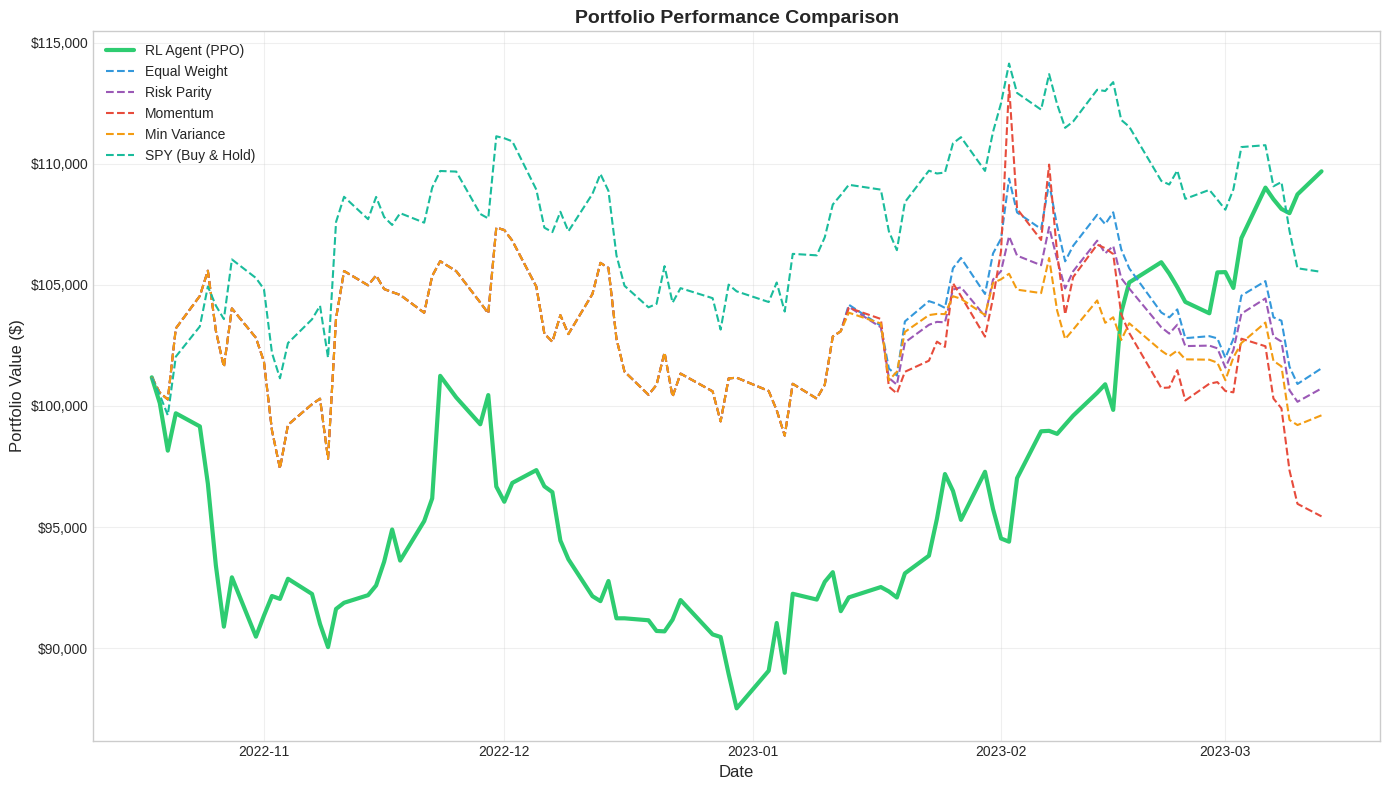

In [20]:
# ============================================
# PORTFOLIO VALUE COMPARISON
# ============================================

initial_capital = 100000

fig, ax = plt.subplots(figsize=(14, 8))

# Calculate portfolio values
dates = test_features.index[:len(rl_returns)]

strategies = {
    'RL Agent (PPO)': rl_metrics['cumulative_returns'],
    'Equal Weight': ew_metrics['cumulative_returns'][:len(rl_returns)],
    'Risk Parity': rp_metrics['cumulative_returns'][:len(rl_returns)],
    'Momentum': mom_metrics['cumulative_returns'][:len(rl_returns)],
    'Min Variance': mv_metrics['cumulative_returns'][:len(rl_returns)],
    'SPY (Buy & Hold)': spy_metrics['cumulative_returns']
}

colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12', '#1abc9c']

for (name, cum_returns), color in zip(strategies.items(), colors):
    portfolio_values = initial_capital * cum_returns
    linewidth = 3 if 'RL' in name else 1.5
    linestyle = '-' if 'RL' in name else '--'
    ax.plot(dates[:len(portfolio_values)], portfolio_values,
            label=name, color=color, linewidth=linewidth, linestyle=linestyle)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Portfolio Value ($)', fontsize=12)
ax.set_title('Portfolio Performance Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.savefig('portfolio_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

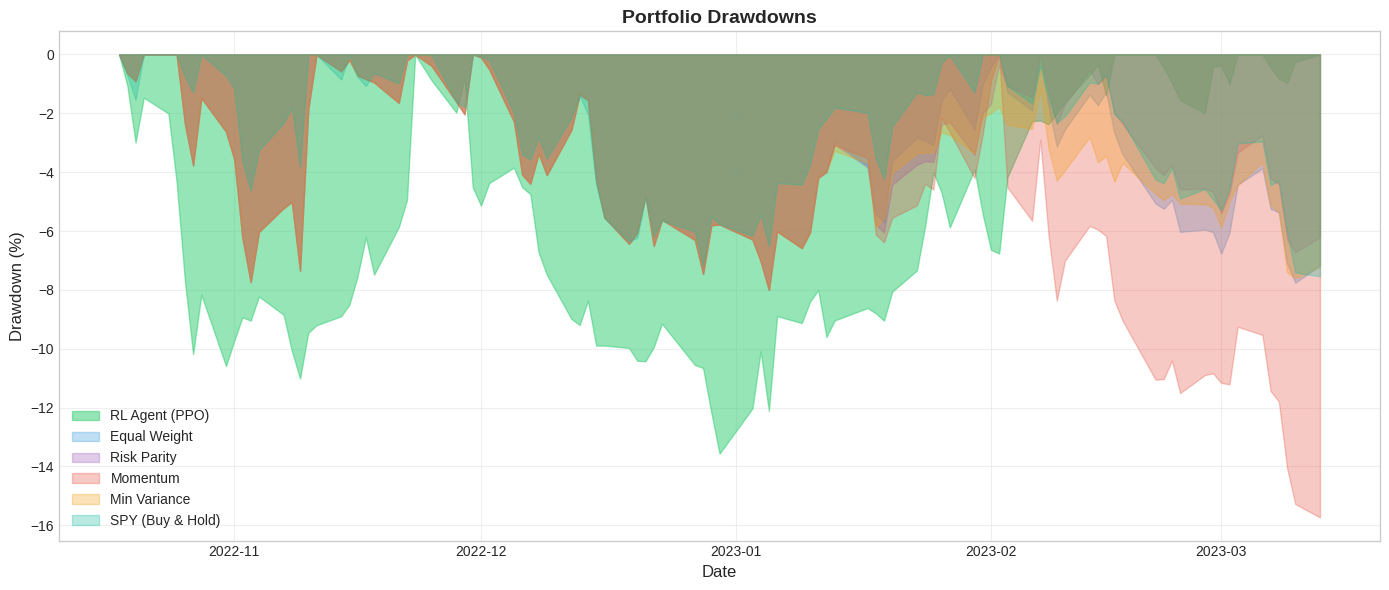

In [21]:
# ============================================
# DRAWDOWN COMPARISON
# ============================================

fig, ax = plt.subplots(figsize=(14, 6))

for (name, cum_returns), color in zip(strategies.items(), colors):
    peak = np.maximum.accumulate(cum_returns)
    drawdown = (peak - cum_returns) / peak * 100

    linewidth = 2 if 'RL' in name else 1
    ax.fill_between(dates[:len(drawdown)], 0, -drawdown,
                    alpha=0.3 if 'RL' not in name else 0.5,
                    label=name, color=color)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Drawdown (%)', fontsize=12)
ax.set_title('Portfolio Drawdowns', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('drawdowns.png', dpi=150, bbox_inches='tight')
plt.show()

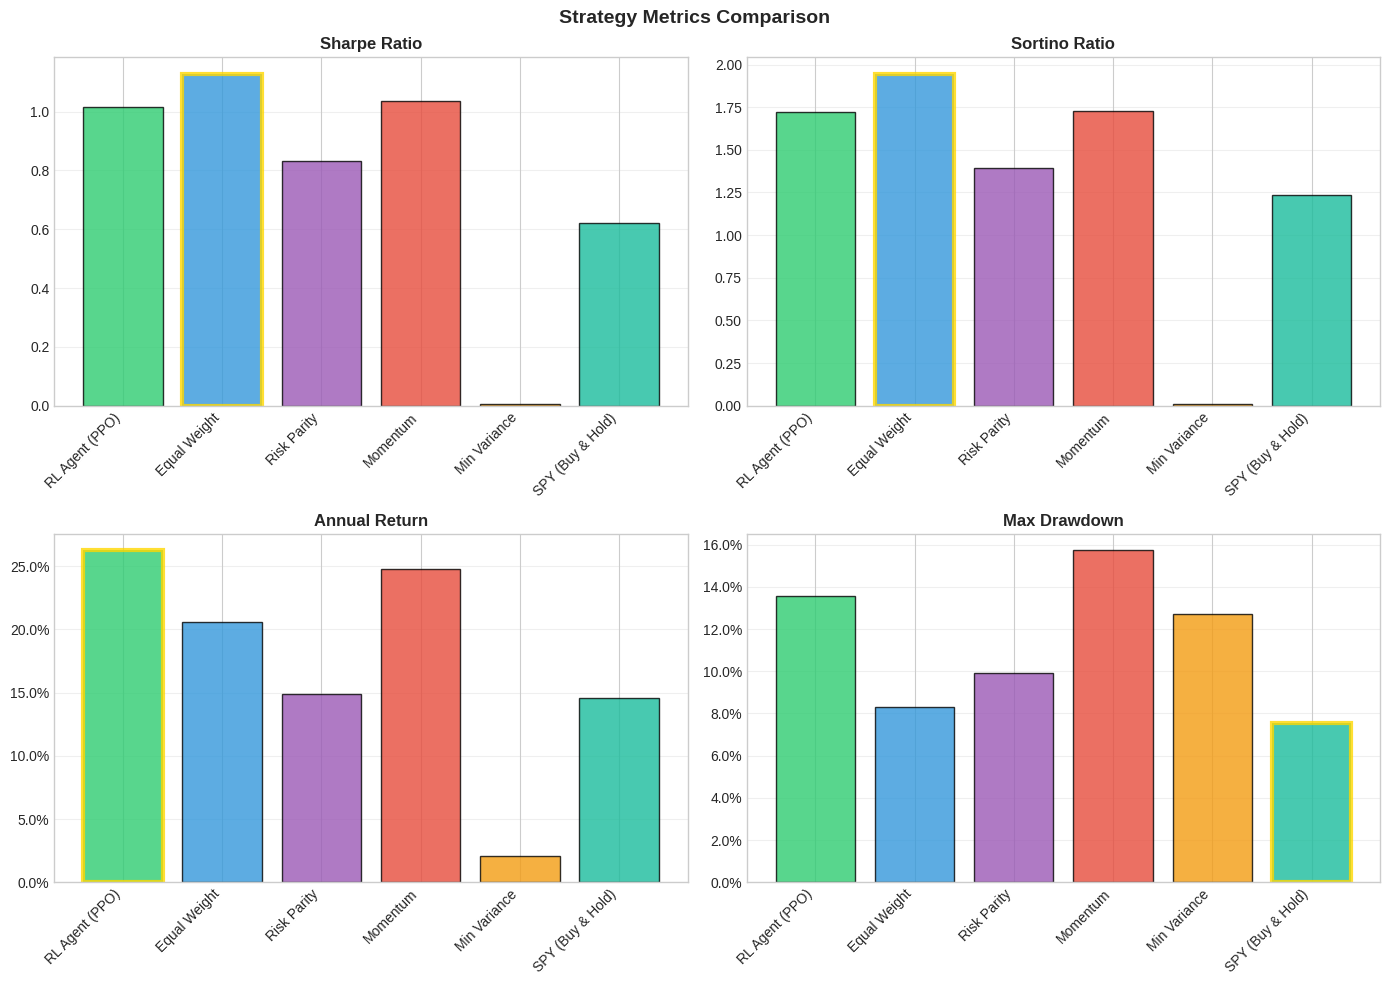

In [22]:
# ============================================
# METRICS BAR CHART
# ============================================

metrics_to_plot = ['sharpe_ratio', 'sortino_ratio', 'annual_return', 'max_drawdown']
metric_labels = ['Sharpe Ratio', 'Sortino Ratio', 'Annual Return', 'Max Drawdown']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

strategy_names = list(results.keys())

for idx, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
    ax = axes[idx]

    values = [results[name][metric] for name in strategy_names]

    bars = ax.bar(strategy_names, values, color=colors, alpha=0.8, edgecolor='black')

    # Highlight best
    if metric == 'max_drawdown':
        best_idx = np.argmin(np.abs(values))
    else:
        best_idx = np.argmax(values)
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(3)

    ax.set_title(label, fontsize=12, fontweight='bold')
    ax.set_xticklabels(strategy_names, rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')

    if metric in ['annual_return', 'max_drawdown']:
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))

plt.suptitle('Strategy Metrics Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

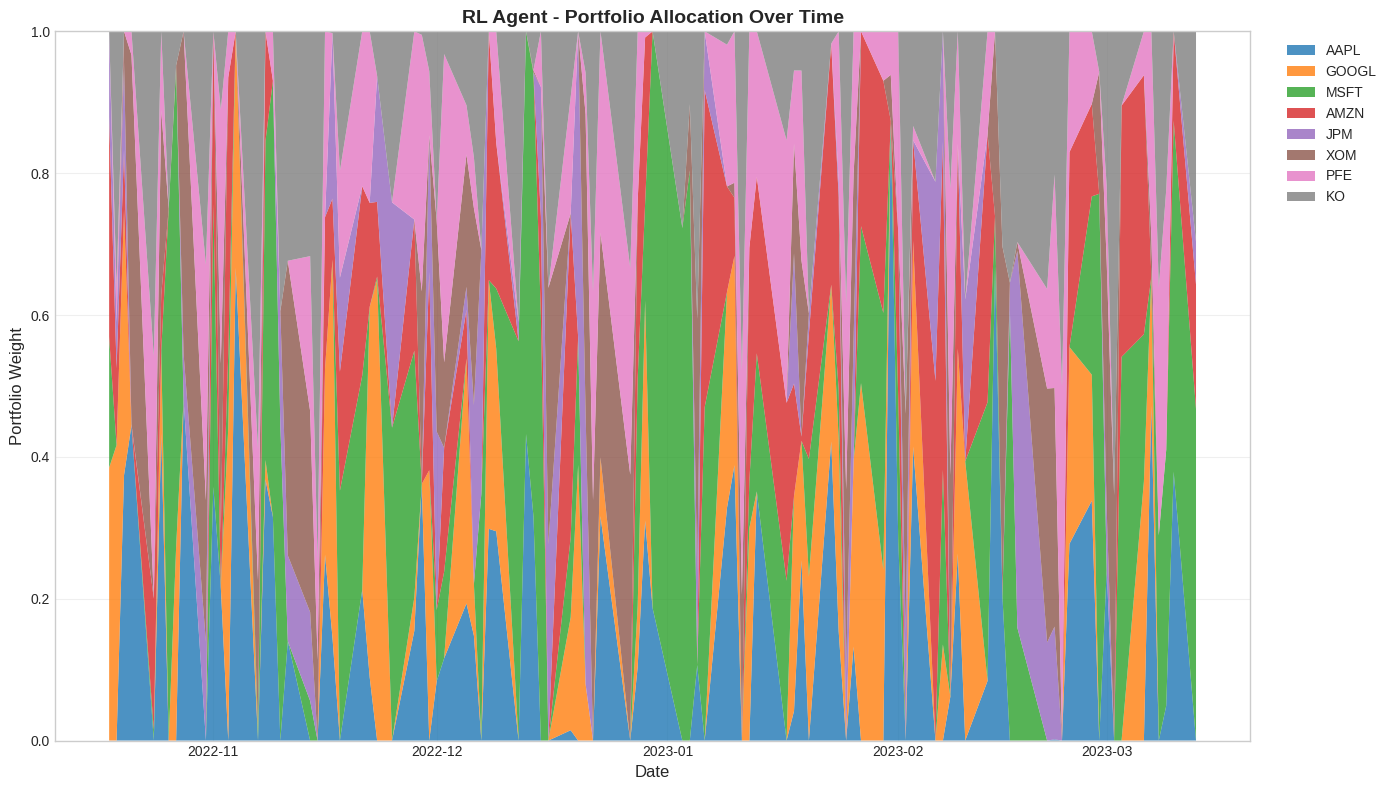

In [23]:
# ============================================
# RL AGENT PORTFOLIO WEIGHTS OVER TIME
# ============================================

fig, ax = plt.subplots(figsize=(14, 8))

weights_df = pd.DataFrame(rl_weights, columns=asset_names, index=dates[: len(rl_weights)])

ax.stackplot(weights_df.index, weights_df.T, labels=asset_names, alpha=0.8)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Portfolio Weight', fontsize=12)
ax.set_title('RL Agent - Portfolio Allocation Over Time', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rl_weights.png', dpi=150, bbox_inches='tight')
plt.show()

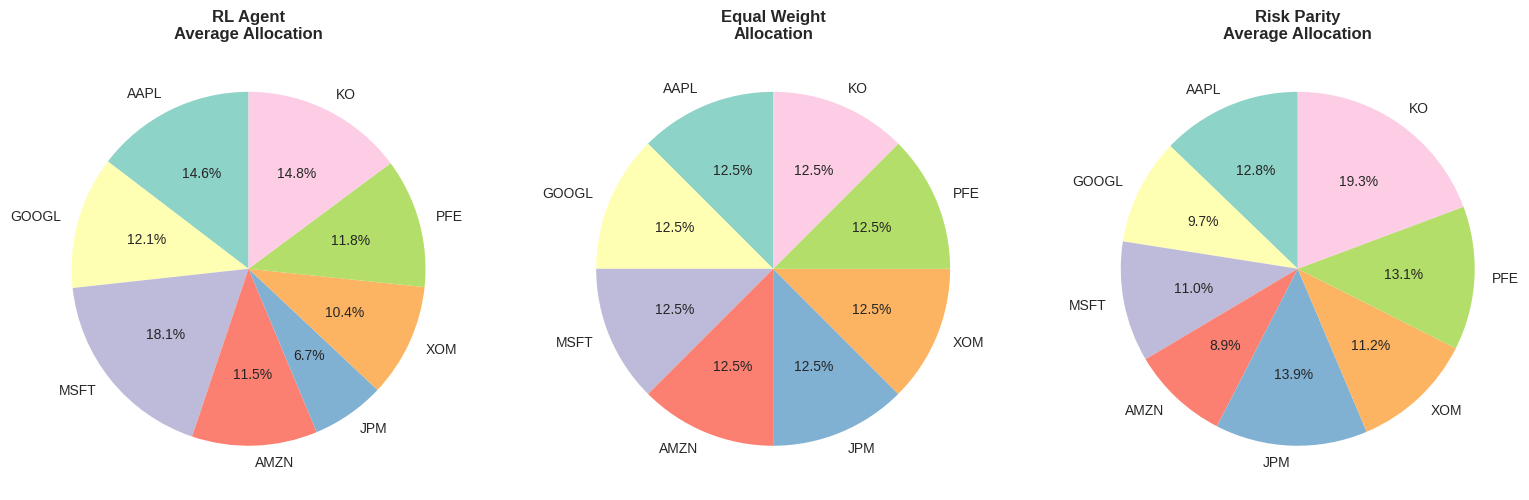

In [24]:
# ============================================
# AVERAGE WEIGHTS COMPARISON
# ============================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# RL Agent average weights
ax1 = axes[0]
avg_rl_weights = rl_weights.mean(axis=0)
ax1.pie(avg_rl_weights, labels=asset_names, autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
ax1.set_title('RL Agent\nAverage Allocation', fontsize=12, fontweight='bold')

# Equal weight
ax2 = axes[1]
equal_weights = np.ones(n_assets) / n_assets
ax2.pie(equal_weights, labels=asset_names, autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
ax2.set_title('Equal Weight\nAllocation', fontsize=12, fontweight='bold')

# Risk Parity average weights
ax3 = axes[2]
avg_rp_weights = rp_weights.mean(axis=0)
ax3.pie(avg_rp_weights, labels=asset_names, autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
ax3.set_title('Risk Parity\nAverage Allocation', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('average_weights.png', dpi=150, bbox_inches='tight')
plt.show()

# Phase 6: Feature Importance Analysis (Simplified)

In [25]:
# ============================================
# PERMUTATION IMPORTANCE (SIMPLIFIED)
# ============================================

print("=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

def evaluate_agent(model, features, returns, n_runs:  int = 3) -> float:
    """Evaluate agent and return average Sharpe ratio."""
    sharpe_ratios = []

    for _ in range(n_runs):
        env = PortfolioEnvFast(features_df=features, returns_df=returns, window_size=WINDOW_SIZE)
        obs, _ = env. reset()
        done = False

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

        metrics = env.get_episode_metrics()
        sharpe_ratios.append(metrics['sharpe_ratio'])

    return np.mean(sharpe_ratios)

# Baseline performance
print("\nCalculating baseline performance...")
baseline_sharpe = evaluate_agent(model, test_features, test_returns)
print(f"Baseline Sharpe Ratio: {baseline_sharpe:.4f}")

# Permutation importance for each feature (asset)
print("\nCalculating permutation importance...")
importance_scores = {}

for col in test_features.columns:
    # Create permuted features
    permuted_features = test_features.copy()
    permuted_features[col] = np.random.permutation(permuted_features[col].values)

    # Evaluate with permuted feature
    permuted_sharpe = evaluate_agent(model, permuted_features, test_returns, n_runs=1)

    # Importance = drop in performance
    importance = baseline_sharpe - permuted_sharpe
    importance_scores[col] = importance
    print(f"  {col}: importance = {importance:.4f}")

FEATURE IMPORTANCE ANALYSIS

Calculating baseline performance...
Baseline Sharpe Ratio: 2.1338

Calculating permutation importance...
  AAPL: importance = 2.5898
  AMZN: importance = -0.2174
  GOOGL: importance = 0.9081
  JPM: importance = 3.5771
  KO: importance = 3.5821
  MSFT: importance = 3.1962
  PFE: importance = 2.1295
  SPY: importance = 0.6636
  XOM: importance = 3.4138


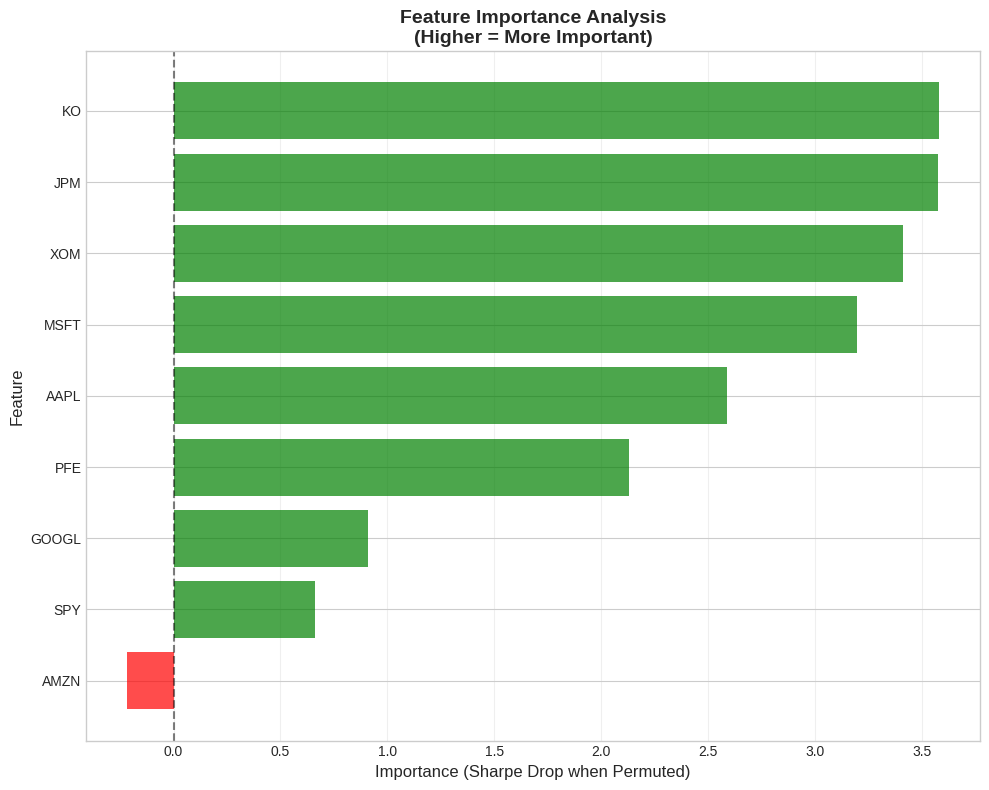

In [26]:
# Visualize feature importance
importance_df = pd.DataFrame({
    'Feature': importance_scores.keys(),
    'Importance':  importance_scores.values()
}).sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['green' if x > 0 else 'red' for x in importance_df['Importance']]
ax.barh(importance_df['Feature'], importance_df['Importance'], color=colors, alpha=0.7)
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Importance (Sharpe Drop when Permuted)', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Feature Importance Analysis\n(Higher = More Important)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary Report

In [27]:
# ============================================
# GENERATE SUMMARY REPORT
# ============================================

print("\n" + "=" * 70)
print("                    PORTFOLIO OPTIMIZATION - SUMMARY REPORT")
print("=" * 70)

print(f"""
📊 DATA SUMMARY
{'─' * 50}
• Assets Traded: {', '.join(asset_names)}
• Training Period: {train_features.index[0]. date()} to {train_features.index[-1].date()}
• Testing Period: {test_features.index[0].date()} to {test_features.index[-1]. date()}
• Training Samples: {len(train_features):,}
• Testing Samples:  {len(test_features):,}

🤖 RL AGENT CONFIGURATION
{'─' * 50}
• Algorithm: PPO (Proximal Policy Optimization)
• Window Size: 50 days
• Transaction Cost: 0.1%
• Training Timesteps: 100,000

📈 RL AGENT PERFORMANCE (Test Period)
{'─' * 50}
• Total Return: {rl_metrics['total_return']:.2%}
• Annualized Return: {rl_metrics['annual_return']:.2%}
• Volatility:  {rl_metrics['volatility']:.2%}
• Sharpe Ratio: {rl_metrics['sharpe_ratio']:.3f}
• Sortino Ratio: {rl_metrics['sortino_ratio']:.3f}
• Max Drawdown: {rl_metrics['max_drawdown']:.2%}
• Win Rate: {rl_metrics['win_rate']:.1%}

🏆 STRATEGY RANKINGS (by Sharpe Ratio)
{'─' * 50}""")

# Rank by Sharpe
sharpe_ranking = sorted(results.items(), key=lambda x: x[1]['sharpe_ratio'], reverse=True)
for rank, (name, metrics) in enumerate(sharpe_ranking, 1):
    print(f"  {rank}. {name}:  {metrics['sharpe_ratio']:.3f}")

print(f"""
📁 SAVED FILES
{'─' * 50}
• Model: portfolio_ppo_model.zip
• Comparison: backtest_comparison.csv
• Charts: price_analysis.png, training_progress.png,
          portfolio_comparison.png, drawdowns. png,
          metrics_comparison.png, rl_weights.png,
          average_weights.png, feature_importance.png
""")

print("=" * 70)
print("                         END OF REPORT")
print("=" * 70)


                    PORTFOLIO OPTIMIZATION - SUMMARY REPORT

📊 DATA SUMMARY
──────────────────────────────────────────────────
• Assets Traded: AAPL, GOOGL, MSFT, AMZN, JPM, XOM, PFE, KO
• Training Period: 2018-01-03 to 2022-10-17
• Testing Period: 2022-10-18 to 2023-12-29
• Training Samples: 1,206
• Testing Samples:  302

🤖 RL AGENT CONFIGURATION
──────────────────────────────────────────────────
• Algorithm: PPO (Proximal Policy Optimization)
• Window Size: 50 days
• Transaction Cost: 0.1%
• Training Timesteps: 100,000

📈 RL AGENT PERFORMANCE (Test Period)
──────────────────────────────────────────────────
• Total Return: 9.69%
• Annualized Return: 26.25%
• Volatility:  23.91%
• Sharpe Ratio: 1.014
• Sortino Ratio: 1.724
• Max Drawdown: 13.56%
• Win Rate: 50.0%

🏆 STRATEGY RANKINGS (by Sharpe Ratio)
──────────────────────────────────────────────────
  1. Equal Weight:  1.128
  2. Momentum:  1.035
  3. RL Agent (PPO):  1.014
  4. Risk Parity:  0.831
  5. SPY (Buy & Hold):  0.622
  6.

In [28]:
# Save summary to file
with open('summary_report.txt', 'w') as f:
    f.write("PORTFOLIO OPTIMIZATION USING DEEP REINFORCEMENT LEARNING\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Generated:  {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    f.write("PERFORMANCE COMPARISON\n")
    f.write("-" * 60 + "\n")
    f.write(comparison_df.to_string())
    f.write("\n\n")
    f.write("STRATEGY RANKINGS (by Sharpe Ratio)\n")
    f.write("-" * 60 + "\n")
    for rank, (name, metrics) in enumerate(sharpe_ranking, 1):
        f.write(f"{rank}. {name}: {metrics['sharpe_ratio']:.3f}\n")

print("\nSummary report saved to 'summary_report.txt'")


Summary report saved to 'summary_report.txt'


# 🎓 Next Steps & Improvements

1. **Feature Engineering**: Add technical indicators (RSI, MACD, Bollinger Bands)
2. **Risk-Adjusted Rewards**: Use Sharpe ratio or Sortino ratio as reward
3. **Advanced Architectures**:  LSTM or Transformer-based policies
4. **Hyperparameter Tuning**:  Optimize learning rate, network architecture
5. **Ensemble Methods**: Combine multiple RL agents
6. **Transaction Costs**: Add more realistic cost models
7. **Constraints**: Add position limits, sector constraints
8. **Live Trading**: Connect to a paper trading API for real-time testing

In [34]:
# Debug: Check where we actually are
import os
import platform

print(f"Platform: {platform.system()}")
print(f"Platform node: {platform.node()}")
print(f"Current working directory: {os.getcwd()}")
print(f"Home directory: {os.path.expanduser('~')}")

Platform: Linux
Platform node: df8e3f4e8047
Current working directory: /Users/yoni/Documents/ML-zoomcamp/Capestone_project
Home directory: /root


In [ ]:
# Save the trained model - trying multiple locations
import os

# Try saving to current working directory (which might be mounted)
save_paths = [
    "portfolio_ppo_fast",  # Current directory
    "/content/portfolio_ppo_fast",  # Colab default
    os.path.expanduser("~/portfolio_ppo_fast"),  # Home directory
]

saved_path = None
for path in save_paths:
    try:
        model.save(path)
        full_path = path + ".zip"
        if os.path.exists(full_path):
            size = os.path.getsize(full_path)
            print(f"✅ Successfully saved to: {full_path}")
            print(f"   File size: {size/1024:.1f} KB")
            saved_path = full_path
            break
    except Exception as e:
        print(f"❌ Failed to save to {path}: {e}")

if saved_path:
    print(f"\n📁 Model saved! You need to download it from: {saved_path}")
    print("If using Colab, use the Files panel on the left to download it.")
else:
    print("\n⚠️ Could not save model to any location")

Current working directory: /content
Changed to: /Users/yoni/Documents/ML-zoomcamp/Capestone_project

✅ Model saved successfully!
   Path: /Users/yoni/Documents/ML-zoomcamp/Capestone_project/portfolio_ppo_fast.zip
   Size: 285.4 KB

📁 Files in directory:
   • portfolio_ppo_fast.zip
